# Example use of the Sonic module Linckii.jl

* https://juliadb.org
* https://julialang.org
* https://juliastats.org

In [2]:
import Pkg                      # package manager
Pkg.activate("..")              # Project.toml
Pkg.instantiate()               # https://julialang.github.io/Pkg.jl/v1.0/index.html

Activating environment at `~/Documents/Calendar/Work/Noda/Code/Sonic.jl/Project.toml`


In [3]:
import Dates, JuliaDB, Random, StatsPlots

In [4]:
using StatsPlots
ENV["GKSwstype"] = "100"
gr(fmt = :png)

Plots.GRBackend()

In [5]:
include("../src/Linckii.jl")
include("../src/LinckiiSecrets.jl")

Main.LinckiiSecrets

Get access token,

In [12]:
@time access = Linckii.get_access(LinckiiSecrets.keab)

  0.000005 seconds (4 allocations: 160 bytes)


(url = "https://canary.noda.se/~keab", key = "e86d93131e6bc12ae701d036e696cf8b")

`GET https://canary.noda.se/~keab/api/v1/nodes`,

In [13]:
@time site_nodes = Linckii.get_nodes(access)

  2.772929 seconds (16.28 k allocations: 1.317 MiB)


Table with 279 rows, 8 columns:
Columns:
#  colname           type
─────────────────────────────────
1  node_public       Bool
2  node_name         String
3  device_id         Int64
4  node_id           Int64
5  node_owner        Bool
6  node_enabled      Bool
7  sensor_ids        Array{Any,1}
8  node_description  String

`GET https://canary.noda.se/~keab/api/v1/devices`,

In [14]:
@time site_devices = Linckii.get_devices(access)

  0.988093 seconds (1.00 k allocations: 51.016 KiB)


Table with 11 rows, 3 columns:
protocol_id  device_name             device_id
──────────────────────────────────────────────
1            "Kelp-IQHeat"           1
2            "Scout"                 2
1            "Kelp-Basic"            4
5            "Weather-Forecast"      6
6            "Grid-Basic"            7
6            "Grid-Controller"       8
7            "Heat-Load-Forecast"    9
2            "CMa1Xw"                10
2            "EcoGuard Sensor"       11
2            "WEPTech"               12
8            "Flexibility-Forecast"  13

`GET https://canary.noda.se/~keab/api/v1/sensors`,

In [15]:
@time site_sensors = Linckii.get_sensors(access)

  1.741072 seconds (7.86 k allocations: 539.734 KiB)


Table with 175 rows, 5 columns:
Columns:
#  colname             type
────────────────────────────────
1  sensor_unit         FreeUnits
2  sensor_name         Symbol
3  protocol_id         Int64
4  sensor_id           Int64
5  sensor_description  String

In [16]:
site = (:nodes => site_nodes, :devices => site_devices, :sensors => site_sensors)
()

()

Save site,

In [17]:
@time Linckii.savesite(access; site...)

  3.063765 seconds (7.63 M allocations: 388.582 MiB, 3.96% gc time)


Load site,

In [18]:
@time site = Linckii.loadsite(access, :nodes, :devices, :sensors)
()

  0.061139 seconds (71.72 k allocations: 3.699 MiB)


()

In [19]:
device_name = Linckii.get_cref(site.devices, :device_id, :device_name)
device_id   = Linckii.get_cref(site.devices, :device_name, :device_id)
()

()

In [20]:
sensor_name = Linckii.get_cref(site.sensors, :sensor_id, :sensor_name)
()

()

Select data,

In [35]:
selected_sensor_names = Dict(
    device_id["Kelp-Basic"] => [
        :meter_effect,
        :meter_heatenergy,
        :meter_primreturntemp,
        :meter_primsupplytemp,
        :meter_volume,
        :meter_volumeflow,
        :outdoortemp,
        :outdoortemp_offset,
    ],
    device_id["Weather-Forecast"] => [
        :cloudiness,
        :outdoortemp,
        :wind_direction,
        :wind_speed,
    ],
)

Dict{Int64,Set{Symbol}} with 2 entries:
  4 => Set(Symbol[:meter_primreturntemp, :meter_effect, :outdoortemp, :meter_pr…
  6 => Set(Symbol[:cloudiness, :outdoortemp, :wind_direction, :wind_speed])

In [53]:
selected_nodes = JuliaDB.filter(
    r -> (
        r.device_id in keys(selected_sensor_names) &&
        Set(sensor_name[r_sensor_id] for r_sensor_id in r.sensor_ids) >= Set(selected_sensor_names[r.device_id])
    ),
    site.nodes,
)

Table with 85 rows, 8 columns:
Columns:
#  colname           type
─────────────────────────────────
1  node_public       Bool
2  node_name         String
3  device_id         Int64
4  node_id           Int64
5  node_owner        Bool
6  node_enabled      Bool
7  sensor_ids        Array{Any,1}
8  node_description  String

Save data,

In [25]:
dates = Dates.DateTime(2017, 12) : Dates.Month(1) : Dates.DateTime(2019, 12)

2017-12-01T00:00:00:1 month:2019-12-01T00:00:00

In [38]:
rs = JuliaDB.rows(selected_nodes)
if true
    rs = [rs[Random.rand(1 : end)]]
end
@time for r in rs
    for r_sensor_name in selected_sensor_names[r.device_id]
        filepath = "$(Linckii.datapath(access, r.node_id, r_sensor_name)).db"
        try
            Linckii.savedata(access, r.node_id, r_sensor_name, dates...)
            println("$(filepath): Done")
        catch e
            println("$(filepath): $(e)")
        end
    end
end

db/linckii/~keab/data/93/meter_primreturntemp.db: Done
db/linckii/~keab/data/93/meter_effect.db: Done
db/linckii/~keab/data/93/outdoortemp.db: Done
db/linckii/~keab/data/93/meter_primsupplytemp.db: Done
db/linckii/~keab/data/93/meter_volumeflow.db: Done
db/linckii/~keab/data/93/meter_volume.db: Done
db/linckii/~keab/data/93/outdoortemp_offset.db: Done
db/linckii/~keab/data/93/meter_heatenergy.db: Done
255.468417 seconds (33.11 M allocations: 1.704 GiB, 0.21% gc time)


Load data,

In [39]:
r = JuliaDB.rows(selected_nodes)[Random.rand(1 : end)]
r_node_id, r_device_id = 93, 4 # r.node_id, r.device_id

(93, 4)

In [49]:
r_sensor_name = collect(selected_sensor_names[r_device_id])[Random.rand(1 : end)]

:meter_effect

In [50]:
data = Linckii.loaddata(access, r_node_id, r_sensor_name)

Table with 48572 rows, 3 columns:
datetime             variable       value
─────────────────────────────────────────
2018-02-14T12:58:06  :meter_effect  45.78
2018-02-14T13:08:06  :meter_effect  46.02
2018-02-14T13:18:06  :meter_effect  62.8
2018-02-14T13:28:05  :meter_effect  62.94
2018-02-14T13:38:06  :meter_effect  38.65
2018-02-14T13:48:13  :meter_effect  83.4
2018-02-14T13:58:06  :meter_effect  44.31
2018-02-14T14:08:05  :meter_effect  44.6
2018-02-14T14:18:14  :meter_effect  26.17
2018-02-14T14:28:06  :meter_effect  62.12
2018-02-14T14:38:06  :meter_effect  42.33
2018-02-14T14:48:05  :meter_effect  42.65
⋮
2019-03-28T06:28:14  :meter_effect  42.39
2019-03-28T06:38:05  :meter_effect  32.0
2019-03-28T06:48:21  :meter_effect  35.62
2019-03-28T06:58:13  :meter_effect  60.58
2019-03-28T07:08:06  :meter_effect  35.64
2019-03-28T07:18:04  :meter_effect  35.03
2019-03-28T07:28:05  :meter_effect  30.62
2019-03-28T07:38:05  :meter_effect  26.64
2019-03-28T07:48:04  :meter_effect  0.0
2019

Simple plot,

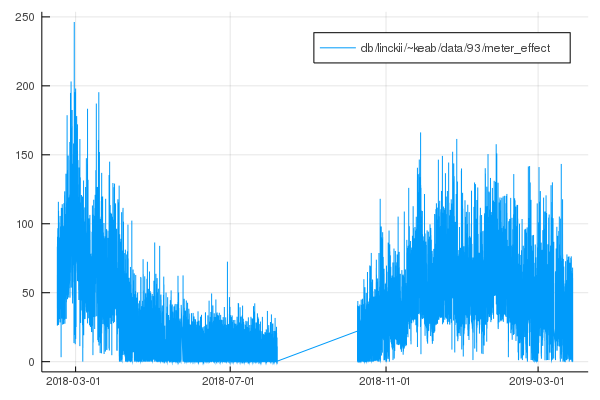

In [52]:
@df data plot(:datetime, :value, label = Linckii.datapath(access, r_node_id, r_sensor_name))